In [1]:
import sys
sys.path.append('../../../')

import numpy as np
import pandas as pd
import torch as tc

from scipy.linalg import lapack

import time
from tqdm import tqdm

#Plotting
import matplotlib.pyplot as plt
import matplotlib


FILE_PATH = "../../../data/DJI.txt"

from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor

from rcgp.weight_functions import IMQ, partial_y_IMQ
from rcgp.rcgp import TemporalRCGP

In [2]:
def get_data(n_days=2):
    crash_date = pd.Timestamp('2013-04-23')
    DJI = pd.read_csv(FILE_PATH, header = None)
    DJI.columns =['date', 'open', 'high', 'low', 'close']
    DJI['date'] = pd.to_datetime(DJI['date'])

    crash_date = pd.Timestamp('2013-04-23')
    dates = list(pd.date_range(end=crash_date, periods=n_days, freq='B').astype(str))
    flash_crash_dji = DJI[DJI.date.dt.date.astype(str).isin(dates)]

    obs_grid = np.linspace(0, 1, len(flash_crash_dji)).reshape(-1,1)
    obs = flash_crash_dji["close"].to_numpy()
    obs_center = obs.mean()
    obs_std = obs.std()
    obs = (obs - obs_center)/obs_std

    return flash_crash_dji, obs_grid, obs, obs_center, obs_std

In [3]:
flash_crash_dji, obs_grid, obs, obs_center, obs_std = get_data(n_days=2)

In [4]:
def gp_sklearn(alpha, obs_grid, obs):

    gpr = GaussianProcessRegressor(kernel= 1.0 * Matern(), alpha=alpha)
    gpr.fit(obs_grid, obs)
    mu_sklearn, std_sklearn = gpr.predict(obs_grid, return_std=True)

    print("kernel parameters:")
    print(gpr.kernel_.get_params())

    return gpr, mu_sklearn, std_sklearn

def gp_sklearn_predict(alpha, obs_grid, obs):
    kernel = 0.72 * Matern(length_scale=0.0955, nu=1.5, length_scale_bounds='fixed')
    gpr = GaussianProcessRegressor(kernel= kernel, alpha=alpha, optimizer=None); #note that we're not optimizing here
    gpr.fit(obs_grid, obs);
    mu_sklearn, std_sklearn = gpr.predict(obs_grid, return_std=True);

    return mu_sklearn, std_sklearn


#Run Sklearn
model_sklearn, mu_sklearn, std_sklearn = gp_sklearn(alpha=0.02, obs_grid=obs_grid, obs=obs)

kernel parameters:
{'k1': 0.849**2, 'k2': Matern(length_scale=0.0955, nu=1.5), 'k1__constant_value': 0.7210007500679416, 'k1__constant_value_bounds': (1e-05, 100000.0), 'k2__length_scale': 0.09553133897501599, 'k2__length_scale_bounds': (1e-05, 100000.0), 'k2__nu': 1.5}


In [5]:
inds_cache = {}

def upper_triangular_to_symmetric(ut):
    n = ut.shape[0]
    try:
        inds = inds_cache[n]
    except KeyError:
        inds = np.tri(n, k=-1, dtype=bool)
        inds_cache[n] = inds
    ut[inds] = ut.T[inds]


def inv(m):
    cholesky, info = lapack.dpotrf(m)
    if info != 0:
        raise ValueError('dpotrf failed on input {}'.format(m))
    inv, info = lapack.dpotri(cholesky)
    if info != 0:
        raise ValueError('dpotri failed on input {}'.format(cholesky))
    upper_triangular_to_symmetric(inv)
    return inv


def rcgp(scale, obs_grid, obs, return_std=True):
    magnitude = 1.
    lengthscale = 0.09
    nu = 1 + 1/2
    matern_kernel = magnitude * Matern(length_scale=lengthscale, nu=nu)

    #m = ((obs[-1] - obs[0])/(obs_grid[-1] - obs_grid[0]) * obs_grid).flatten()
    m = np.zeros_like(obs_grid, dtype=np.float32).flatten() + obs.mean()

    beta= 1.
    c= 0.25


    K = matern_kernel(obs_grid.reshape(-1,1))
    

    w = IMQ(Y=obs, m=m, beta=beta, c=c).astype(np.float32)
    partial_w = partial_y_IMQ(Y=obs, m=m, beta=beta, c=c).astype(np.float64)

    J_w = np.diag((scale**2 / 2) * w**(-2))

    m_w = m + 2 * scale**2 * (w)**(-1) * partial_w

    A = inv(K + scale**2 * J_w)

    mu_rcgp = m + K @ A @ (obs - m_w)

    if return_std:
        Sigma = K @ A @ (scale**2 * J_w)
        std_rcgp = np.sqrt(np.diag(Sigma))
    
        return mu_rcgp.flatten(), std_rcgp

    else:
        return mu_rcgp.flatten()
    
def rcgp_predict(scale, obs_grid, obs):
    magnitude = 1.
    lengthscale = 0.09
    nu = 1 + 1/2
    matern_kernel = magnitude * Matern(length_scale=lengthscale, nu=nu)

    #m = ((obs[-1] - obs[0])/(obs_grid[-1] - obs_grid[0]) * obs_grid).flatten()
    m = np.zeros_like(obs_grid, dtype=np.float32).flatten() + obs.mean()

    beta= 1.
    c= 0.25


    K = matern_kernel(obs_grid.reshape(-1,1))
    

    w = IMQ(Y=obs, m=m, beta=beta, c=c).astype(np.float32)
    partial_w = partial_y_IMQ(Y=obs, m=m, beta=beta, c=c).astype(np.float64)

    J_w = np.diag((scale**2 / 2) * w**(-2))

    m_w = m + 2 * scale**2 * (w)**(-1) * partial_w

    A = inv(K + scale**2 * J_w)

    return m + K @ A @ (obs - m_w)


mu_rcgp, std_rcgp = rcgp(0.2, obs_grid, obs)

In [6]:
def get_rtgp(obs_grid, obs):
    with tc.no_grad():
        #rtgp = SpatioTemporalRCGP(ts=tc.from_numpy(obs_grid).reshape(-1,1), grid=None, Ys=tc.from_numpy(obs).reshape(-1,1), p=2)
        rtgp = TemporalRCGP(ts=tc.from_numpy(obs_grid).reshape(-1,1), Ys=tc.from_numpy(obs).reshape(-1,1), p=2)
        rtgp.activate_robustness(func="m_pred")

        rtgp.temporal_lengthscale = 0.1
        rtgp.temporal_magnitude = 1. 

        rtgp.beta = 1.
        rtgp.adaptive_c()
        #rtgp.c = 0.5


        rtgp.var_y = 0.02
        (preds_smooth, stds_smooth, eff), _, _ = rtgp.forward()
        
        return preds_smooth, stds_smooth, eff, rtgp

mu_rtgp, std_rtgp, eff, rtgp_model = get_rtgp(obs_grid=obs_grid, obs=obs)

In [7]:
def get_comp_time(n_max):
    n_vals = np.arange(1, n_max+1)
    rtgp_times = []
    rcgp_times = []
    gp_times = []
    dataset_size = []


    for n in tqdm(n_vals):
        flash_crash_dji, obs_grid, obs, obs_center, obs_std = get_data(n_days=n)

        t1 = time.time()
        _=get_rtgp(obs_grid=obs_grid, obs=obs)
        t2 = time.time()

        rtgp_times.append(t2 - t1)
        
        t1 = time.time()
        _=rcgp_predict(scale=0.2, obs_grid=obs_grid, obs=obs)
        t2 = time.time()
        rcgp_times.append(t2 - t1)

        t1 = time.time()
        _=gp_sklearn_predict(alpha=0.02, obs_grid=obs_grid, obs=obs)
        t2 = time.time()
        gp_times.append(t2 - t1)

        dataset_size.append(len(obs))

    df = pd.DataFrame(np.vstack([rtgp_times, rcgp_times, gp_times, dataset_size]), columns=n_vals, index=['rtgp', 'rcgp', 'gp', 'size'])
    
    return df.T

def avg_comp_time(n_max):
    df = get_comp_time(n_max)

    for i in range(4):
        df+= get_comp_time(n_max)

    return df * (1/5)


#df = get_comp_time(30) #Only run if needed. Results are stored in "runtime.csv"
"""df.to_csv(COMP_TIME_OUTPUT_FILE)
"""

'df.to_csv(COMP_TIME_OUTPUT_FILE)\n'

In [8]:
#Number of Data Points
len(flash_crash_dji)

810

In [70]:
rp_mean = np.loadtxt("relevance_pursuit_mean.txt")
rp_dates = pd.to_datetime(np.loadtxt("relevant_pursuit_dates.txt"))

### Animation

In [13]:
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter
from IPython import display
from matplotlib.animation import PillowWriter

In [98]:
plt.rc('font', family='serif', size=15)
matplotlib.rcParams['lines.linewidth'] = 2.5

def get_fig():
    fig, axs = plt.subplots(1, 1, figsize=(8,4))

    dates = pd.to_datetime(flash_crash_dji.date)

    idx1 = (dates >= '2013-04-23') & (dates <= dates.iloc[-50])

    x1 = dates[idx1]

    axs.set_xlim(x1.iloc[10], x1.iloc[-1])


    fontweight = 'normal'
    axs.set_ylabel("DJIA Index", fontweight = fontweight, fontsize=16)
    axs.set_title('April 23rd, 2013', fontweight = fontweight, fontsize=16)

    axs.set_xlabel("Time (Hour)", fontsize=16)

    ymin = 14550
    ymax = max(obs* obs_std + obs_center) + 10

    axs.set_ylim(ymin, ymax)


    for spine in axs.spines.values():
        spine.set_linewidth(2)  # Set border thickness
    for spine in axs.spines.values():
        spine.set_linewidth(2)  # Set border thickness


    axs.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H'))


    plt.subplots_adjust(wspace=0.015)
    fig.tight_layout()


    return fig, axs


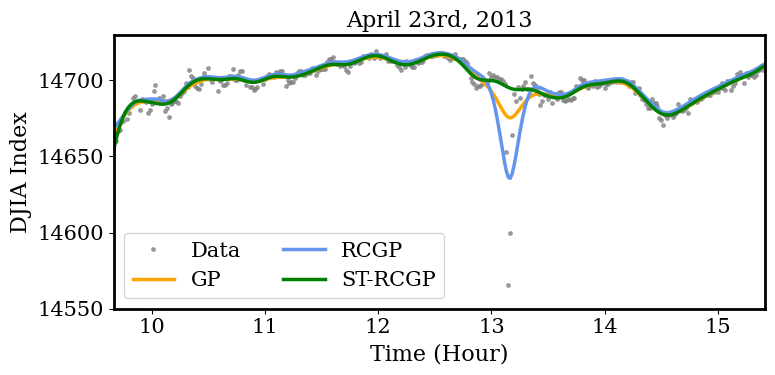

In [107]:
fig, axs = get_fig()


dates = pd.to_datetime(flash_crash_dji.date)

idx1 = (dates >= '2013-04-23') & (dates <= dates.iloc[-50])
x1 = dates[idx1]

pred_rtgp = mu_rtgp.flatten().numpy()

outlier_min_idx = obs[idx1].argmin() - 1
outlier_max_idx = obs[idx1].argmin() + 3


x_arrays = [
    x1,
    x1, 
    x1,
    x1,
]

y_arrays = [
    obs[idx1]* obs_std + obs_center,
    mu_sklearn[idx1]* obs_std + obs_center,
    mu_rcgp[idx1]* obs_std + obs_center,
    pred_rtgp[idx1]* obs_std + obs_center,
]

colors = [
    'gray',
    'orange',
    'cornflowerblue',
    'green',
]



labels = [
    "Data",
    "GP",
    "RCGP",
    "ST-RCGP",
]


lines0 = []


for j in range(4):
    
    if j==0:
        line, = axs.plot([], [], '.', markersize=5, color=colors[j], alpha=0.7, label=labels[j])
    else:
        line, = axs.plot([], [], '-', color=colors[j], label=labels[j])
    
    lines0.append(line)



def init():
    """
    This function will run once at the start,
    clearing any existing data from the lines.
    """
    for line in lines0:
        line.set_data([], [])

    return lines0


def animate(i):
    """
    For frame i, plot each line from index 0 up to i.
    Thus, each line "grows" with every new frame.
    """

    for line, x_arr, y_arr in zip(lines0, x_arrays, y_arrays):
        line.set_data(x_arr[:i], y_arr[:i])
    
    if i == 1:
        axs.legend(loc='lower left', ncol=2)


    return lines0

num_frames = len(x_arrays[0])  # assuming all have the same length

ani = FuncAnimation(
    fig,              # figure to animate
    animate,          # function to call on each frame
    init_func=init,   # initialization function (clear lines)
    frames=num_frames,
    interval=50,      # delay between frames in milliseconds
    blit=True         # improves performance on most backends
)

writer = PillowWriter(fps=50)
ani.save("my_animation.gif", writer=writer)